In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import sys

In [18]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')

In [19]:
from imp import reload

In [40]:
def append_path(module_path):
    if module_path not in sys.path:
        sys.path.append(module_path)

append_path(os.path.abspath('..'))

from preprocess import essay_documents, process_arg_essays_for_conll

In [165]:
import read_annotations
import show_metrics
reload(read_annotations);
reload(essay_documents);
reload(process_arg_essays_for_conll);

## Read annotations

In [122]:
document_pairs = read_annotations.get_annotated_documents()
document_pairs

Support T2 T1
Support T1 T3
Support T6 T5
Attack T8 T9
Support T9 T7
Support T11 T12
Support T13 T15
Support T18 T21
Support T19 T21
Support T20 T21
Support T21 T17
Support T16 T21
Support T17 T22
Support T23 T24
Support T28 T27
Support T27 T29
Support T25 T27
Support T26 T27
Support T30 T29
Support T31 T35
Support T33 T35
Support T34 T35
Support T35 T32
Support T36 T41
Support T37 T41
Support T38 T40
Support T39 T40
Support T40 T41
Support T43 T42
Attack T44 T42
Support T1 T3
Support T4 T3
Support T2 T3
Support T6 T5
Attack T9 T7
Support T14 T13
Support T15 T16
Support T18 T17
Support T17 T14
Support T19 T14
Support T23 T22
Support T26 T22
Support T22 T28
Support T30 T29
Support T31 T32
Support T8 T7
Attack T11 T7
Support T33 T17
Support T34 T17
Support T13 T16
Support T10 T14
Support T12 T14
Support T20 T14
Support T21 T23
Support T25 T23
Support T24 T23
Duplicate T22 T30
Support T35 T38
Support T27 T38
Support T36 T38
Support T37 T38
Attack T38 T29
Support T39 T32
Support T40 T32


[(Case: ALKASI v. TURKEY - Ann: S, Case: ALKASI v. TURKEY - Ann: M)]

## Pairing annotations

### Aligning components
We consider two components aligned if they share 80% of the tokens

In [123]:
doc1, doc2 = document_pairs[0]

In [148]:
def are_aligned(interval1, interval2, plot=False):
    if interval1[0] < interval2[0]:
        start1, end1 = interval1
        start2, end2 = interval2
    elif interval1[0] > interval2[0]:
        start1, end1 = interval2
        start2, end2 = interval1
    else:  # They are equal, we need the interval 1 to be the shorter
        start1, end1 = interval1 if interval1[1] < interval2[1] else interval2
        start2, end2 = interval1 if interval1[1] >= interval2[1] else interval2
    overlap = end1 - start2
    if plot:
        plt.figure(figsize=(6, 2))
        sns.pointplot((interval1[0], interval2[0],interval1[1],interval2[1]),
                      (1,1,1,1), hue=['doc1', 'doc2', 'doc1', 'doc2'])
        plt.show()
    if overlap > (end1 - start1)*0.8 and overlap > (end2 - start2)*0.7:
        return True
    return False

def get_aligned_components(doc1, doc2):
    """Returns a list with components that are aligned between documents"""
    component_starts2 = sorted(doc2.annotated_components.keys())
    component_starts1 = sorted(doc1.annotated_components.keys())
    aligned_components = {}
    # Go through the components of doc1 in ordered fashion.
    while len(component_starts1) is not 0 and len(component_starts2) is not 0:
        start1 = component_starts1[0]
        end1 = doc1.annotated_components[start1]
        start2 = component_starts2[0]
        end2 = doc2.annotated_components[start2]
        # Check if the first components in the stacks are aligned.
        if are_aligned((start1, end1), (start2, end2)):
            aligned_components[start1] = start2
            component_starts2.pop(0)
            component_starts1.pop(0)
        elif start1 >= start2:  # component2 can't be aligned
            component_starts2.pop(0)
        elif start1 <= start2:  # component2 can still be aligned, but not component1
            component_starts1.pop(0)
    return aligned_components

In [149]:
aligned_components = get_aligned_components(doc1, doc2)

Proportion of aligned components

In [151]:
for doc1, doc2 in document_pairs:
    print('[{0}] {1:.2f} - [{2}] {3:.2f}'.format(
        doc1.identifier.replace('Case: ', ''),
        len(aligned_components)/float(len(doc1.annotated_components)),
        doc2.identifier.replace('Case: ', ''),
        len(aligned_components)/float(len(doc2.annotated_components))))

[ALKASI v. TURKEY - Ann: S] 0.64 - [ALKASI v. TURKEY - Ann: M] 0.67


### Aligning relations

In [153]:
doc2.annotated_relations

defaultdict(dict,
            {1615: {1903: 'Support'},
             1772: {1903: 'Support'},
             2096: {1903: 'Support'},
             2471: {2354: 'Support'},
             2802: {2665: 'Attack'},
             2938: {2665: 'Support'},
             3112: {2665: 'Attack'},
             3314: {7761: 'Support'},
             3489: {7761: 'Support'},
             3787: {7761: 'Support'},
             5311: {7681: 'Support'},
             5800: {7681: 'Support'},
             7196: {7761: 'Support'},
             7528: {7681: 'Support'},
             7681: {7761: 'Support'},
             7761: {7840: 'Support'},
             7840: {8123: 'Support'},
             7978: {8123: 'Support'},
             9623: {10500: 'Support'},
             9816: {10130: 'Support'},
             9973: {10130: 'Support'},
             10063: {10130: 'Support'},
             10130: {10500: 'Support'},
             10500: {12072: 'Duplicate', 12361: 'Support'},
             10796: {11974: 'Support'},
   

In [156]:
def align_relations(doc1, doc2):
    aligned_relations = []
    # We iterate over the components
    for arg1_start1, arg1_start2 in aligned_components.items():
        if not (arg1_start1 in doc1.annotated_relations.keys() and
                arg1_start2 in doc2.annotated_relations.keys()):
            continue
        # Check if the relations are equal
        # We iterate over the relations starting from that component.
        for arg2_start1 in doc1.annotated_relations[arg1_start1].keys():
            if arg2_start1 not in aligned_components:
                # The second argument of the relation is not aligned, then
                # the relation is not aligned
                continue
            # The second component is aligned, now we check if the same relation
            # exists on the second document
            arg2_start2 = aligned_components[arg2_start1]
            if arg2_start2 in doc2.annotated_relations[arg1_start2]:
                # The relation is aligned!!
                aligned_relations.append(
                    ((arg1_start1, arg2_start1),(arg1_start2, arg2_start2)))
    return aligned_relations

In [159]:
aligned_relations = align_relations(doc1, doc2)

Proportion of aligned relations

In [160]:
for doc1, doc2 in document_pairs:
    print('[{0}] {1:.2f} - [{2}] {3:.2f}'.format(
        doc1.identifier.replace('Case: ', ''),
        len(aligned_relations)/float(len(doc1.annotated_relations)),
        doc2.identifier.replace('Case: ', ''),
        len(aligned_relations)/float(len(doc2.annotated_relations))))

[ALKASI v. TURKEY - Ann: S] 0.37 - [ALKASI v. TURKEY - Ann: M] 0.33


## Agreement on aligned relations

In [162]:
def aligned_labels(aligned_relations, doc1, doc2):
    labels1 = []
    labels2 = []
    for (arg1_start1, arg2_start1), (arg1_start2, arg2_start2) in aligned_relations:
        labels1.append(doc1.annotated_relations[arg1_start1][arg2_start1])
        labels2.append(doc2.annotated_relations[arg1_start2][arg2_start2])
    return labels1, labels2

Observed Agreement: 100.00%


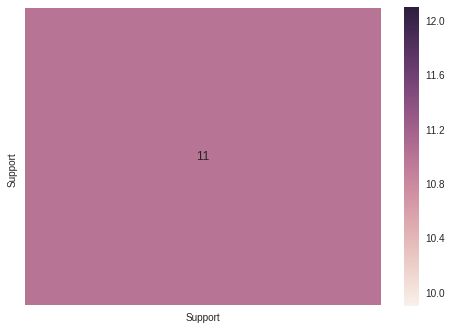

In [167]:
labels1, labels2 = aligned_labels(aligned_relations, doc1, doc2)
show_metrics.show_confusion_matrix(labels1, labels2)